In [9]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

In [10]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [11]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Je charge mes datasets

In [24]:
BATCH_SIZE = 32
IMG_SIZE = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classe en one hot

In [26]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=120)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=120)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=120)))

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Utilisation de mobilenet v2

In [29]:
base_model = keras.applications.ResNet50V2(
                        include_top=False, # Exclude ImageNet classifier at the top
                        weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)
                        )

94668760/94668760 [==============================] - 3s 0us/step


In [30]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [31]:
base_model.trainable = False
# base_model.summary()

Pour générer des prédictions à partir du bloc d'entités, effectuez une moyenne sur les emplacements spatiaux 5x5 , à l'aide d'une couche tf.keras.layers.GlobalAveragePooling2D pour convertir les entités en un seul vecteur de 1 280 éléments par image.

In [33]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [34]:
# prediction_layer = tf.keras.layers.Dense(120, activation='softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [35]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

On construit le modèle

In [36]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
model = keras.Model(inputs, outputs)

In [38]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [39]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [42]:
EPOCHS = 25

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=validation_dataset, 
                    verbose=1,
                    callbacks =[earlystopping])

Epoch 1/25
449/449 [==============================] - 147s 327ms/step - loss: 1.9920 - categorical_accuracy: 0.4933 - val_loss: 1.0778 - val_categorical_accuracy: 0.6929
Epoch 2/25
449/449 [==============================] - 146s 325ms/step - loss: 1.4593 - categorical_accuracy: 0.6047 - val_loss: 1.0545 - val_categorical_accuracy: 0.7143
Epoch 3/25
449/449 [==============================] - 146s 324ms/step - loss: 1.2599 - categorical_accuracy: 0.6536 - val_loss: 1.0904 - val_categorical_accuracy: 0.7088
Epoch 4/25
449/449 [==============================] - 146s 324ms/step - loss: 1.1708 - categorical_accuracy: 0.6763 - val_loss: 1.0686 - val_categorical_accuracy: 0.7145
Epoch 5/25
449/449 [==============================] - 145s 324ms/step - loss: 1.0743 - categorical_accuracy: 0.6954 - val_loss: 1.0713 - val_categorical_accuracy: 0.7178
Epoch 6/25
449/449 [==============================] - 147s 328ms/step - loss: 1.0116 - categorical_accuracy: 0.7080 - val_loss: 1.1013 - val_categoric

In [44]:
loss0, accuracy0 = model.evaluate(test_dataset)

34/34 [==============================] - 3s 77ms/step - loss: 0.9602 - categorical_accuracy: 0.7177


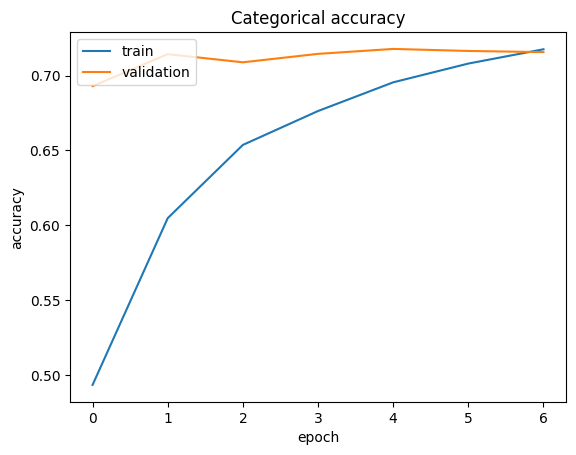

In [45]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)